In [ ]:
# Mounting Google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Importing Libraries
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import PIL
from PIL import Image
import cv2
import shutil
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from IPython.display import display

In [ ]:
# Giving dataset path
dataset_path = '/content/drive/MyDrive/CXR_png'
no_tb_dir = os.path.join(dataset_path, 'No-TB')
tb_dir = os.path.join(dataset_path, 'TB')

# Create subdirectories if they don't exist
os.makedirs(no_tb_dir, exist_ok=True)
os.makedirs(tb_dir, exist_ok=True)

# Move files to respective subdirectories
for file in os.listdir(dataset_path):
    if file.endswith('_0.png'):
        shutil.move(os.path.join(dataset_path, file), os.path.join(no_tb_dir, file))
    elif file.endswith('_1.png'):
        shutil.move(os.path.join(dataset_path, file), os.path.join(tb_dir, file))

print(f"Organized files into subdirectories: {no_tb_dir} and {tb_dir}")



Organized files into subdirectories: /content/drive/MyDrive/CXR_png/No-TB and /content/drive/MyDrive/CXR_png/TB


In [ ]:
dataset_path = '/content/drive/MyDrive/CXR_png'
if os.path.exists(dataset_path):
    for subdir in os.listdir(dataset_path):
        subdir_path = os.path.join(dataset_path, subdir)
        if os.path.isdir(subdir_path):
            print(f"Checking subdirectory: {subdir}")
            files = os.listdir(subdir_path)
            image_files = [f for f in files if f.lower().endswith(('png', 'jpg', 'jpeg'))]
            print(f"Found {len(image_files)} image files in {subdir}")
else:
    print(f"Dataset directory does not exist: {dataset_path}")

Checking subdirectory: No-TB
Found 80 image files in No-TB
Checking subdirectory: TB
Found 58 image files in TB


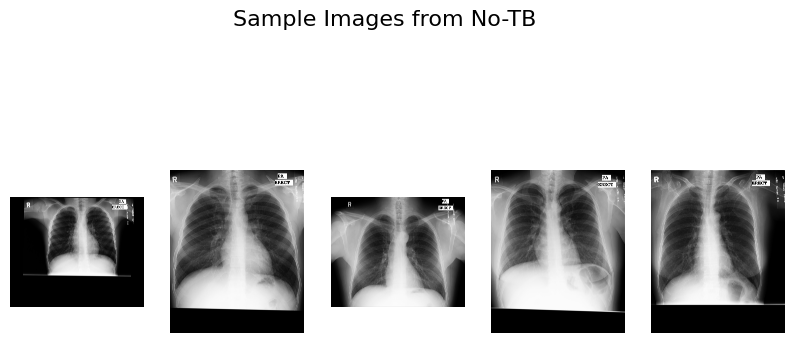

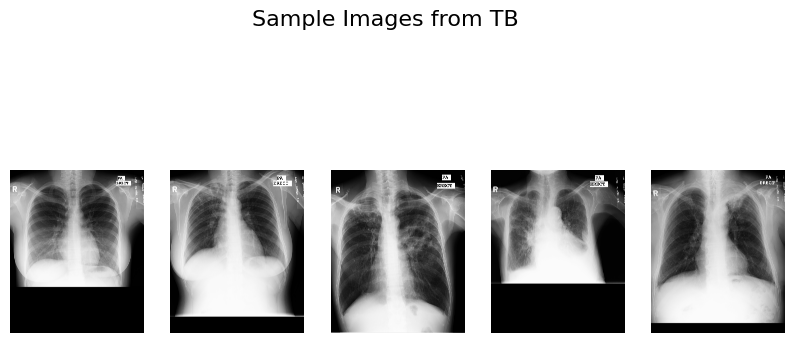

In [ ]:
#sampling few images of TB and No-TB

dataset_path = '/content/drive/MyDrive/CXR_png'
if os.path.exists(dataset_path):
    subdirs = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]
    for subdir in subdirs:
        subdir_path = os.path.join(dataset_path, subdir)
        image_files = [f for f in os.listdir(subdir_path) if f.lower().endswith(('png', 'jpg', 'jpeg'))][:5]

        plt.figure(figsize=(10, 5))
        plt.suptitle(f"Sample Images from {subdir}", fontsize=16)

        for i, img_file in enumerate(image_files):
            img_path = os.path.join(subdir_path, img_file)
            img = Image.open(img_path)
            plt.subplot(1, 5, i + 1)
            plt.imshow(img, cmap='gray')
            plt.axis('off')

        plt.show()
else:
    print(f"Dataset directory does not exist: {dataset_path}")

In [ ]:
# Loading and Preprocessing Data
# Using the dataset located in '/content/drive/MyDrive/CXR_png'
data_gen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
train_data = data_gen.flow_from_directory('/content/drive/MyDrive/CXR_png', target_size=(224, 224), batch_size=32, class_mode='binary', subset='training', color_mode='grayscale')
test_data = data_gen.flow_from_directory('/content/drive/MyDrive/CXR_png', target_size=(224, 224), batch_size=32, class_mode='binary', subset='validation', color_mode='grayscale')

# Parameters
IMG_SIZE = 128  # Resize to 128x128
X = []
y = []

# Path to the folder containing subdirectories
folder_path = '/content/drive/MyDrive/CXR_png'

# Load and preprocess data from subfolders
for subdir in os.listdir(folder_path):
    subdir_path = os.path.join(folder_path, subdir)
    if os.path.isdir(subdir_path):
        for filename in os.listdir(subdir_path):
            if filename.endswith('.png'):
                # Determine label based on subdirectory name
                label = 0 if subdir == 'No-TB' else 1

                # Load and preprocess the image
                img_path = os.path.join(subdir_path, filename)

                # Load grayscale image
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

                # Histogram Equalization
                img_eq = cv2.equalizeHist(img)

                # Resize
                img_resized = cv2.resize(img_eq, (IMG_SIZE, IMG_SIZE))

                # Normalize
                img_norm = img_resized / 255.0

                X.append(img_norm)
                y.append(label)

# Convert to numpy arrays
X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 1)  # Reshape for model input
y = np.array(y)

Found 111 images belonging to 2 classes.
Found 27 images belonging to 2 classes.


In [ ]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Train set:", X_train.shape, y_train.shape)
print("Test set:", X_test.shape, y_test.shape)

Train set: (110, 128, 128, 1) (110,)
Test set: (28, 128, 128, 1) (28,)


In [ ]:
# Building Neural Network Model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 1)),  # Changing input shape to (224, 224, 1)
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

In [ ]:
#Compile the model
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 222, 222, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 186624)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │    23,888,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,906,945 (91.20 MB)

 Trainable params: 23,906,945 (91.20 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Training the Model
history = model.fit(train_data, validation_data=test_data, epochs=10)


Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 52s 15s/step - accuracy: 0.5638 - loss: 1.6183 - val_accuracy: 0.5926 - val_loss: 0.7630
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 44s 11s/step - accuracy: 0.5521 - loss: 1.4853 - val_accuracy: 0.5556 - val_loss: 0.6687
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 45s 11s/step - accuracy: 0.6963 - loss: 0.6154 - val_accuracy: 0.6296 - val_loss: 0.6428
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 42s 10s/step - accuracy: 0.7847 - loss: 0.4762 - val_accuracy: 0.6667 - val_loss: 0.6513
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 42s 10s/step - accuracy: 0.8430 - loss: 0.3553 - val_accuracy: 0.6667 - val_loss: 0.7246
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 43s 10s/step - accuracy: 0.8764 - loss: 0.2691 - val_accuracy: 0.6667 - val_loss: 0.7188
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 45s 13s/step - accuracy: 0.9385 - loss: 0.1677 - val_accuracy: 0.7407 - val_loss: 0.7388
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 46s 10s/step - accuracy: 0.9528 - loss: 0.1297 - val_accuracy: 0.7037 - val_loss: 0.7539


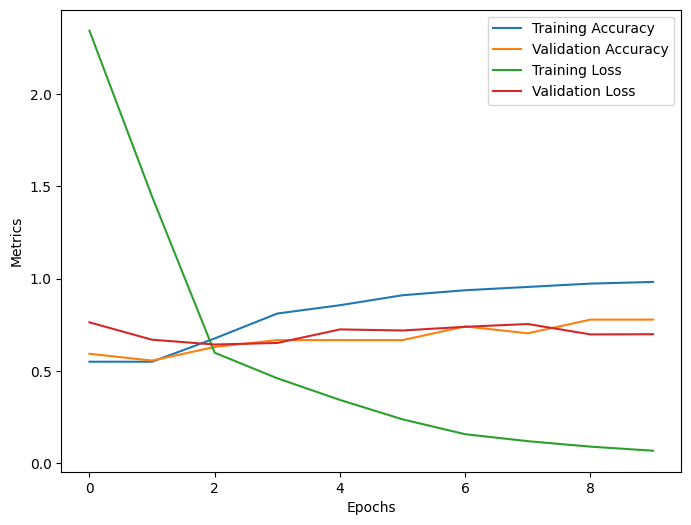

In [ ]:
# Evaluating the Model
# Accuracy and Loss Plot
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


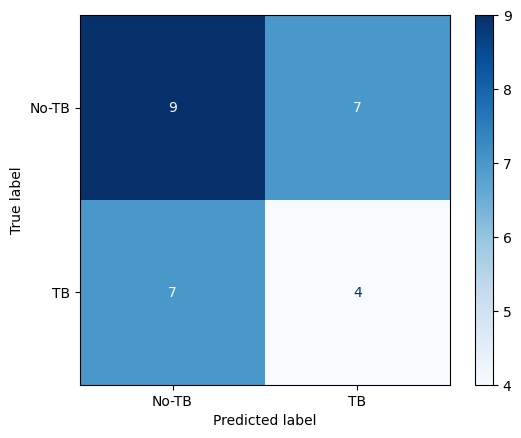

In [ ]:
# Confusion Matrix
y_pred = model.predict(test_data).flatten()
y_pred = (y_pred > 0.5).astype(int)
y_true = test_data.classes
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_data.class_indices.keys())
disp.plot(cmap='Blues')
plt.show()

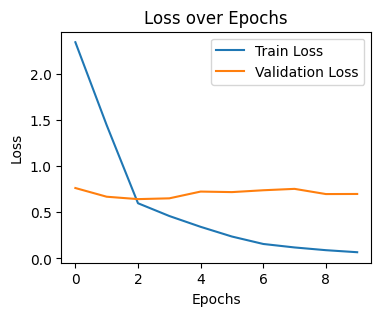

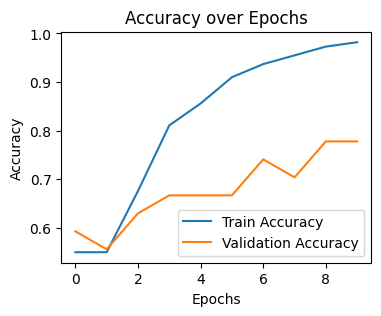

In [ ]:
# Loss plot with smaller figure size
plt.figure(figsize=(4, 3))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.show()
# Accuracy plot with smaller figure size
plt.figure(figsize=(4, 3))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()
plt.show()

In [ ]:
#Testing the Model on a New Image
def load_and_preprocess_image(image_path):
    img = Image.open(image_path).convert('L')
    img = img.resize((224, 224))
    img_array = np.array(img) / 255.0  # Normalize
    img_array = np.expand_dims(img_array, axis=-1)
    img_array = np.expand_dims(img_array, axis=0)
    return img_array
def predict_image(model, image_path):
    img_array = load_and_preprocess_image(image_path)
    prediction = model.predict(img_array)
    return 'TB' if prediction[0][0] > 0.5 else 'No TB'
# Example usage
image_path = '/content/drive/MyDrive/CXR_png/TB/MCUCXR_0104_1.png'
result = predict_image(loaded_model, image_path)
print(f"Prediction for the image {image_path}: {result}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
Prediction for the image /content/drive/MyDrive/CXR_png/TB/MCUCXR_0104_1.png: TB


In [ ]:
image_path = '/content/drive/MyDrive/CXR_png/No-TB/MCUCXR_0001_0.png'
result = predict_image(loaded_model, image_path)
print(f"Prediction for the image {image_path}: {result}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Prediction for the image /content/drive/MyDrive/CXR_png/No-TB/MCUCXR_0001_0.png: No TB
